In [1]:
import pandas as pd
import datetime as dt
import matplotlib
import matplotlib.pyplot as pp
import seaborn as sns
import numpy as np
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler

get_ipython().magic(u'matplotlib inline')

In [2]:
#inspect data, remove empty columns and change datatype
#data.info()
data = pd.read_csv('sensor.csv')
data = data.drop(['Unnamed: 0','sensor_15'], axis=1)
data[['timestamp']] = data[['timestamp']].apply(pd.to_datetime)
ts = data.set_index('timestamp')
#ts.info()

In [3]:
#roll up to 30 min intervals and label the interval in which the machine broke
def func(alarms):
    return 1 if np.any(alarms == 'BROKEN') else 0

ts_hourly_machine_status = ts['machine_status'].resample('30min').apply(func)
ts_hourly_machine_status = pd.DataFrame(ts_hourly_machine_status)
ts_hourly = ts.resample('30min').mean()
ts_hourly_fill_na = ts_hourly.interpolate()

merged = ts_hourly_fill_na.join(ts_hourly_machine_status)

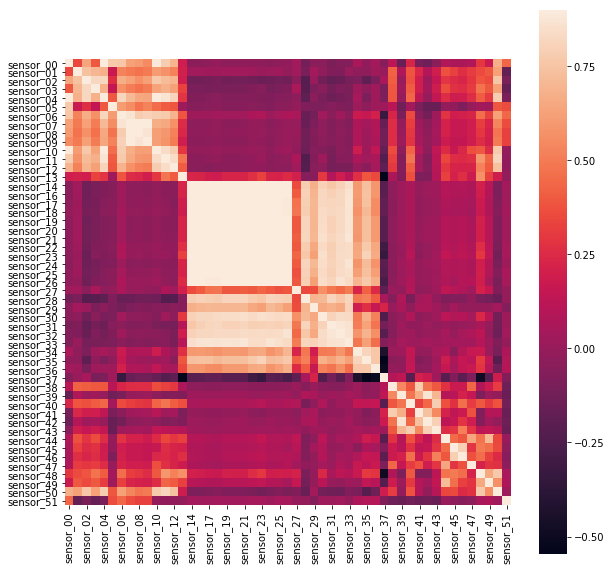

In [4]:
corrmat = ts_hourly.corr()
pp.subplots(figsize=(10, 10))
sns.heatmap(corrmat, vmax=.9, square=True)

In [5]:
corr_absolute = ts.corr().abs()

corr_unstacked = corr_absolute.unstack()
#corr_unstacked
corr_sorted = pd.DataFrame(corr_unstacked.sort_values(kind="quicksort", ascending = False))

corr_sorted = corr_sorted.reset_index()
corr_sorted.columns = ['first_sensor','second_sensor','corr']
corr_sorted_highest = corr_sorted[(corr_sorted['corr'] < 1) & (corr_sorted['corr'] > 0.99)]

corr_sorted_highest

,first_sensor,second_sensor,corr
51,sensor_19,sensor_20,0.998227
52,sensor_20,sensor_19,0.998227
53,sensor_20,sensor_21,0.997075
54,sensor_21,sensor_20,0.997075
55,sensor_19,sensor_21,0.995974
56,sensor_21,sensor_19,0.995974
57,sensor_16,sensor_14,0.990359
58,sensor_14,sensor_16,0.990359


//anaconda/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
//anaconda/lib/python3.4/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
//anaconda/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:32: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


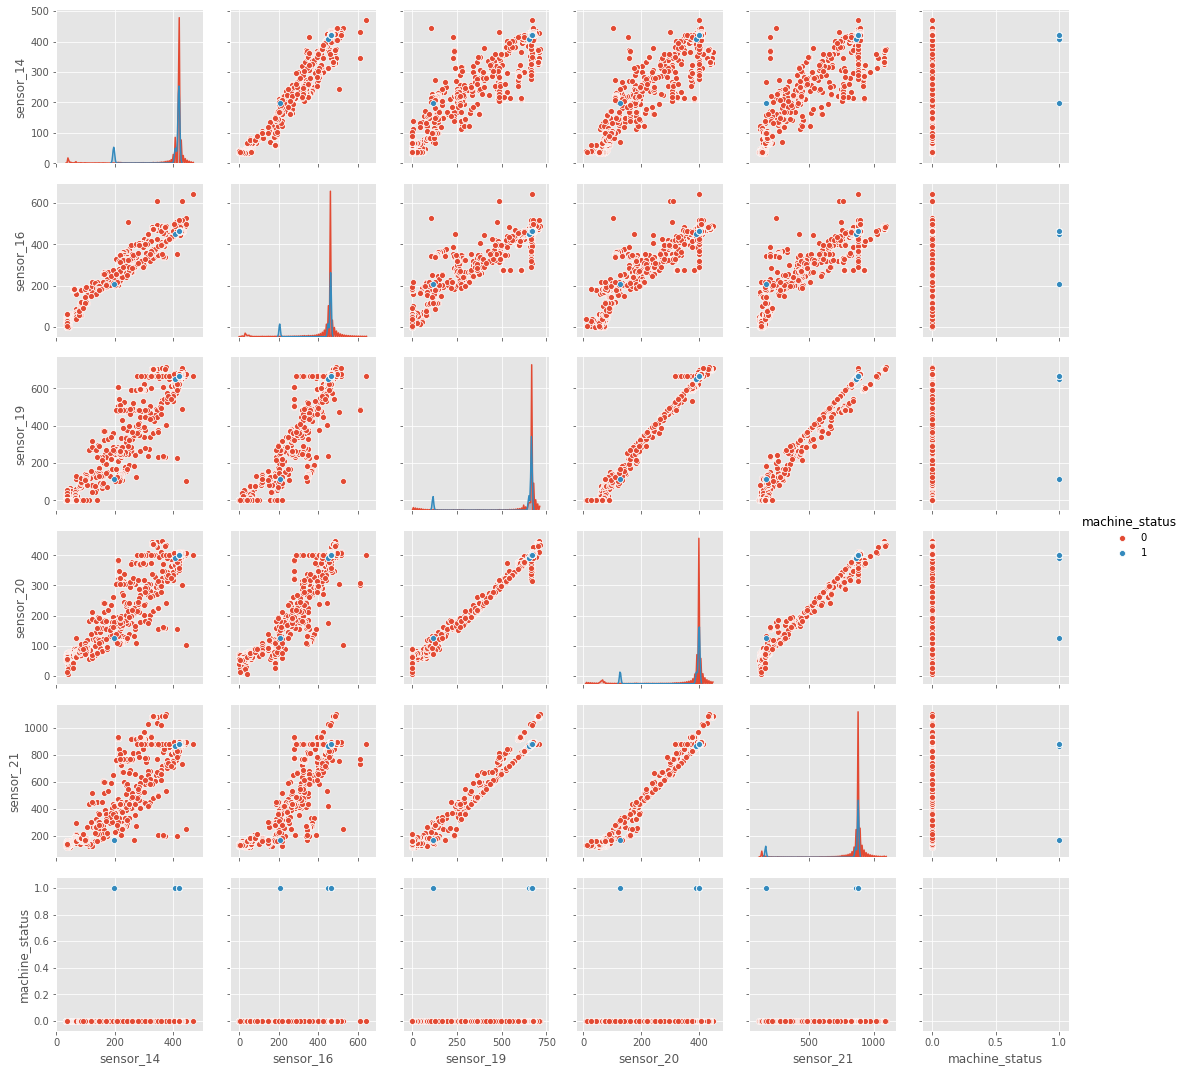

In [6]:
#doublecheck before removing variables

corr_test = ['sensor_14', 'sensor_16', 'sensor_19', 'sensor_20', 'sensor_21', 'machine_status']

matplotlib.style.use('ggplot')

sns_plot = sns.pairplot(merged[corr_test], hue='machine_status')

In [7]:
#remove sensors 16,20 and 21

In [8]:
#split in training and test

In [9]:
ts_interpolated_train = merged['2018-04-01':'2018-07-01']
ts_interpolated_train['machine_status'].value_counts()

0    4411
1       5
Name: machine_status, dtype: int64

In [10]:
ts_interpolated_test = merged['2018-07-02':]
ts_interpolated_test['machine_status'].value_counts()

0    2926
1       2
Name: machine_status, dtype: int64

In [11]:
#merged.info()
feature_list = list(merged.columns)
feature_list.remove('machine_status')
feature_list.remove('sensor_20')
feature_list.remove('sensor_21')
feature_list.remove('sensor_16')

#feature_list =['sensor_04','sensor_11','sensor_10','sensor_12']
#tried more limited feature set but no improvement

In [12]:
#upsample minority class

y_train = ts_interpolated_train['machine_status']
X_train = ts_interpolated_train[feature_list]
X_test = ts_interpolated_test[feature_list]
y_test = ts_interpolated_test['machine_status']

sm = SMOTE(random_state=42, ratio = 1.0, k_neighbors = 4)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [13]:
pd.Series(y_train).value_counts()

1    4411
0    4411
dtype: int64

In [14]:
np.random.seed(0)
clf_rf = RandomForestClassifier(n_jobs=-1, random_state=0, n_estimators=10)
clf_rf.fit(X_train, y_train)

y_pred_rf = clf_rf.predict(X_test)

In [15]:
rf_feature_importance = list(zip((clf_rf.feature_importances_) , ts_interpolated_test[feature_list]))
feature_imp = pd.DataFrame(rf_feature_importance)
feature_imp.columns =['score','feature']

In [16]:
feature_imp_sorted = feature_imp.sort_values(['score'], ascending = False)

In [17]:
#feature_imp_sorted

In [18]:
feature_subset = list(feature_imp_sorted['feature'].iloc[1:10,])
feature_subset.append('machine_status')

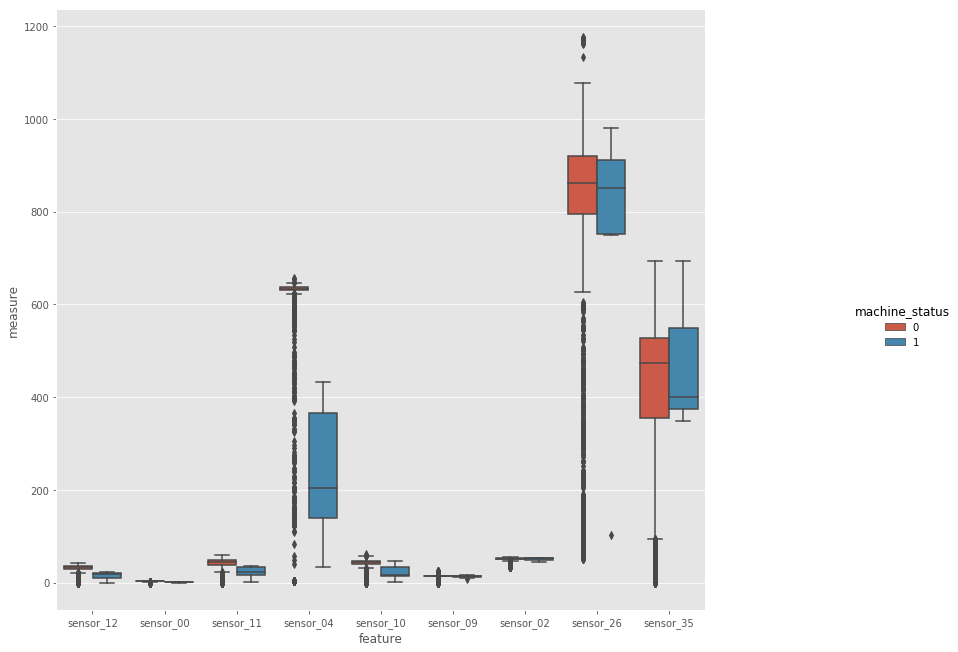

In [19]:
melted = pd.melt(merged[feature_subset], "machine_status", var_name="feature", value_name="measure")

g = sns.catplot(x="feature", hue="machine_status", y="measure", data=melted, kind="box")

g.fig.set_size_inches(15,10)

In [20]:
cnf_matrix_rf = metrics.confusion_matrix(y_test, y_pred_rf)
cnf_matrix_rf

array([[2926,    0],
       [   2,    0]])

In [21]:
#scale values for SVM
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train_sc = scaling.transform(X_train)
X_test_sc = scaling.transform(X_test)


In [22]:
clf_svm_poly = svm.SVC(kernel='poly', C = 0.000001, gamma = 1)
clf_svm_lin = svm.SVC(kernel='linear', C = 0.0000001, gamma = 1)
#tried out different Cs manually

clf_svm_poly.fit(X_train_sc, y_train)  
clf_svm_lin.fit(X_train_sc, y_train)

y_pred_svm_poly = clf_svm_poly.predict(X_test_sc)
y_pred_svm_lin = clf_svm_lin.predict(X_test_sc)

In [23]:
cnf_matrix_svm_poly = metrics.confusion_matrix(y_test, y_pred_svm_poly)
cnf_matrix_svm_poly

array([[2818,  108],
       [   0,    2]])

In [24]:
cnf_matrix_svm_lin = metrics.confusion_matrix(y_test, y_pred_svm_lin)
cnf_matrix_svm_lin

array([[2760,  166],
       [   0,    2]])

In [25]:
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_ada.fit(X_train, y_train)  
y_pred_ada = clf_ada.predict(X_test)

In [26]:
cnf_matrix_ada = metrics.confusion_matrix(y_test, y_pred_ada)
cnf_matrix_ada

array([[2926,    0],
       [   2,    0]])

In [27]:
xx=[]
yy=[]
for i in range(1,20):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train) 
    y_pred_knn = neigh.predict(X_test)
    err = mean_squared_error(y_test, y_pred_knn)
    xx.append(i)
    yy.append(err)

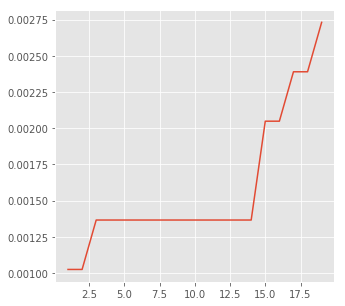

In [28]:
pp.rcParams['figure.figsize'] = [5, 5]
pp.plot(xx,yy)

In [29]:
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X_train, y_train) 
y_pred_knn = neigh.predict(X_test)
cnf_matrix_knn = metrics.confusion_matrix(y_test, y_pred_knn)
cnf_matrix_knn

array([[2925,    1],
       [   2,    0]])

In [30]:
#best model : cnf_matrix_svm_poly, detects all failures, but also classifies 108 of 2926 (3.6%) non-failures as failures
print(classification_report(y_test, y_pred_svm_poly))

             precision    recall  f1-score   support

          0       1.00      0.96      0.98      2926
          1       0.02      1.00      0.04         2

avg / total       1.00      0.96      0.98      2928



In [31]:
#TODO
#refactor to show all sampling approaches
#refactor to systematically test different models (functions, loops)
#refactor to systematically tune svm
#cross-validation
#better assess accuracy, precision and recall and F1-score
